In [1]:
'''Install non-standard libraries'''
%pip install import-ipynb

Note: you may need to restart the kernel to use updated packages.


In [2]:
'''Generic Imports'''
import pandas as pd
import numpy as np
import warnings
from scipy.stats import randint, uniform, zscore
import import_ipynb

'''Visualization Imports'''
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from prettytable import PrettyTable

'''Import Data'''
from sklearn.datasets import load_digits, fetch_california_housing

'''Import Data Processing Utilities'''
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

'''Import Predictors'''
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

'''Import Model Tuning Utilities'''
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

'''Import Metrics'''
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    mean_squared_error, 
    mean_absolute_error, 
    r2_score, 
    explained_variance_score, 
    max_error, 
    mean_squared_log_error, 
    median_absolute_error, 
    mean_absolute_percentage_error, 
    mean_poisson_deviance,
    mean_gamma_deviance
)

'''Tuning Utility'''
from tune import ModelTuner

'''Suppress Warnings'''
warnings.filterwarnings("ignore")

In [3]:
'''Import Classifier data'''
digits = load_digits()


[Pipeline] ............. (step 1 of 2) Processing scale, total=   0.0s
[Pipeline] .......... (step 2 of 2) Processing classify, total=   0.0s
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        53
           1       0.78      0.78      0.78        50
           2       0.82      0.77      0.79        47
           3       0.76      0.89      0.82        54
           4       0.81      0.83      0.82        60
           5       0.94      0.91      0.92        66
           6       0.88      0.94      0.91        53
           7       0.94      0.84      0.88        55
           8       0.82      0.84      0.83        43
           9       0.83      0.83      0.83        59

    accuracy                           0.86       540
   macro avg       0.86      0.85      0.85       540
weighted avg       0.86      0.86      0.86       540



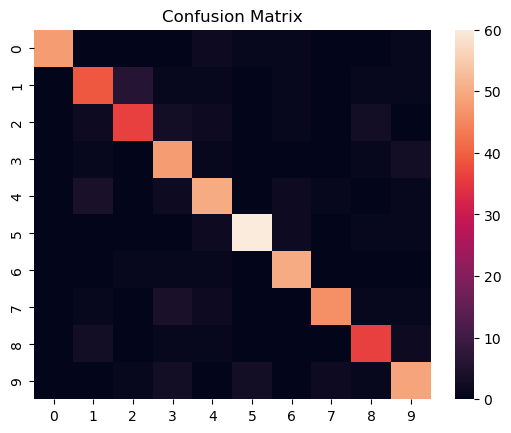

[Pipeline] ............. (step 1 of 2) Processing scale, total=   0.0s
[Pipeline] .......... (step 2 of 2) Processing classify, total=   0.2s
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        53
           1       0.96      1.00      0.98        50
           2       1.00      1.00      1.00        47
           3       0.98      0.94      0.96        54
           4       0.95      1.00      0.98        60
           5       0.97      0.97      0.97        66
           6       1.00      0.98      0.99        53
           7       0.98      0.98      0.98        55
           8       0.95      0.95      0.95        43
           9       0.97      0.95      0.96        59

    accuracy                           0.98       540
   macro avg       0.98      0.98      0.98       540
weighted avg       0.98      0.98      0.98       540



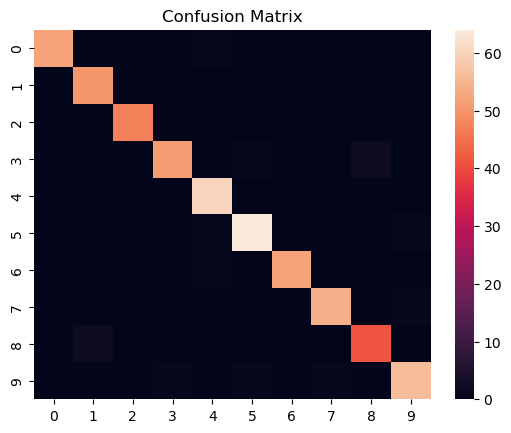

In [4]:
'''Instantiate and Evaluate Default Classifiers'''
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.3, random_state=42)
for model in [DecisionTreeClassifier, RandomForestClassifier]:
    pipe = Pipeline([
        ('scale', StandardScaler()),
        # ('pca', PCA()), PCA Unused due to negative impact on model performance
        ('classify',model())],
    verbose=True)
    predicted = pipe.fit(X_train, y_train).predict(X_test)
    print(classification_report(y_test, predicted))
    sns.heatmap(confusion_matrix(y_test, predicted))
    plt.title('Confusion Matrix')
    plt.show()

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        53
           1       0.09      1.00      0.17        50
           2       0.00      0.00      0.00        47
           3       0.00      0.00      0.00        54
           4       0.00      0.00      0.00        60
           5       0.00      0.00      0.00        66
           6       0.00      0.00      0.00        53
           7       0.00      0.00      0.00        55
           8       0.00      0.00      0.00        43
           9       0.00      0.00      0.00        59

    accuracy                           0.09       540
   macro avg       0.01      0.10      0.02       540
weighted avg       0.01      0.09      0.02       540



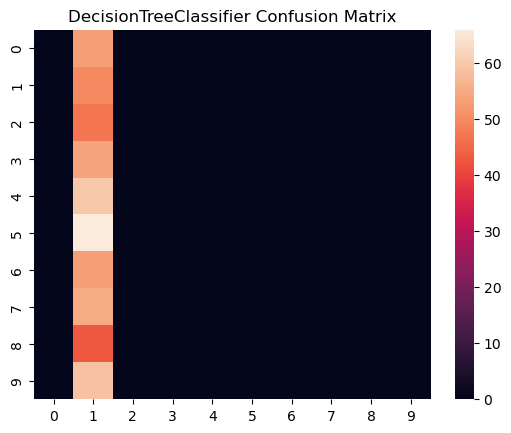

              precision    recall  f1-score   support

           0       0.88      0.94      0.91        53
           1       0.78      0.50      0.61        50
           2       0.66      0.83      0.74        47
           3       0.69      0.89      0.77        54
           4       0.79      0.97      0.87        60
           5       0.93      0.20      0.33        66
           6       0.71      0.98      0.83        53
           7       0.59      0.93      0.72        55
           8       0.67      0.09      0.16        43
           9       0.64      0.75      0.69        59

    accuracy                           0.71       540
   macro avg       0.73      0.71      0.66       540
weighted avg       0.74      0.71      0.67       540



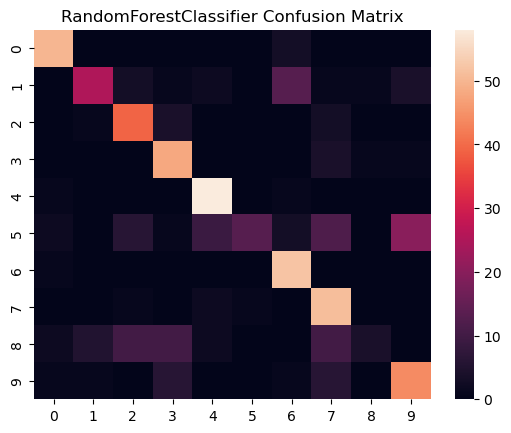

In [5]:
'''Instantiate and Tune Classifiers'''

classifiers = {
    DecisionTreeClassifier.__name__: {
        'model': DecisionTreeClassifier,
        'paramSpace': {
            'classify__criterion': Categorical(['gini', 'entropy', 'log_loss']),
            'classify__splitter': Categorical(['best', 'random']),
            'classify__max_depth': Integer(1, 1000),
            'classify__min_samples_split': Real(0.01, 0.9),
            'classify__min_samples_leaf': Real(0.01, 0.9),
            'classify__min_weight_fraction_leaf': Real(0.0,0.5),
            'classify__max_features': Real(0.01,0.9),
            'classify__max_leaf_nodes': Integer(2, 4000), 
            'classify__min_impurity_decrease': Real(0.0, 1.0),
            'classify__ccp_alpha': Real(0.01, 0.9),
            'pca__n_components': Integer(1,len(digits.data[0])),
            'scaler__with_mean': [True, False],
            'scaler__with_std': [True, False],
        }
    },
    
    RandomForestClassifier.__name__: {
        'model': RandomForestClassifier,
        'paramSpace': {
            'classify__n_estimators': Integer(10, 2000),
            'classify__criterion': Categorical(['gini', 'entropy', 'log_loss']),
            'classify__max_depth': Integer(1, 1000), 
            'classify__min_samples_split': Real(0.01, 0.9), 
            'classify__min_samples_leaf': Real(0.01, 0.9),
            'classify__min_weight_fraction_leaf': Real(0.01,0.5),
            'classify__max_features': Real(0.01,0.9),
            'classify__max_leaf_nodes': Integer(1,2000),
            'classify__min_impurity_decrease': Real(0.01,0.9),
            # 'classify__bootstrap': Categorical([True, False]),
            'classify__oob_score': Categorical([True, False]),
            'classify__warm_start': Categorical([True, False]),
            'classify__max_samples':Real(0.01,0.9),
            'pca__n_components': Integer(1,len(digits.data[0])),
            'scaler__with_mean': [True, False],
            'scaler__with_std': [True, False],
        }
    }
}

tunedModels = {}

X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.3, random_state=42)
for name, classDict in classifiers.items():
    
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA()),
        ('classify',classDict['model']())],
    verbose=False)

    tunedModels[name] = BayesSearchCV(
        pipe,
        classDict['paramSpace'],
        n_iter= 5,#30, # Reduced for performance during development
        cv= 4,#20, # Reduced for performance during development
        scoring='accuracy',
        # TODO: Use GridSearch for scoring criteria
        # NOTE: This will take 13 hours. Execute over night.
        random_state=42
        )
    tunedModels[name].fit(X_train, y_train)
    
    # search = BayesSearchCV(pipe, param_grid, n_jobs=2)
    # predicted = search.best_estimator_.predict(X_test)
    predicted = tunedModels[name].best_estimator_.predict(X_test)
    
    print(classification_report(y_test, predicted))
    sns.heatmap(confusion_matrix(y_test, predicted))
    plt.title(name + ' Confusion Matrix')
    plt.show()




In [6]:
'''Import Regression Data'''
cal_housing = fetch_california_housing(as_frame=True)



In [7]:
'''Data Cleaning and Pre-Processing'''
cleanData = cal_housing.data
cleanData['y'] = cal_housing.target

cleanData = cleanData.drop(columns=['Longitude', 'Latitude'])
for feature in ['AveBedrms', 'AveRooms', 'AveOccup', 'Population']:
    cleanData = cleanData[(np.abs(zscore(cleanData[feature])) < 2.5)]
cleanTarget = cleanData['y'].to_list()

# DATA CLEANING TODOs
# TODO: Bin Lat/Long groupings into city/town clusters. look for available geo-fencing data for cluster labeling - can we do a graph of centroids on top of map?
# TODO: Fix Skew for Population, MedIncome, AvgOccup, AvgBedroom, Target
# TODO: Feature Engineering / Reduction
cleanData.drop(columns=['y'], inplace=True)

In [8]:
'''Instantiate and Evaluate Default Regressors'''
modelData = cleanData.copy()

# TODO: How does normalization vs standardization impact model performance
transformPipeline = [
    ('scaler', StandardScaler()),
    # ('feature_reduction', PCA(n_components=5,iterated_power=7))
    ]

X_train, X_test, y_train, y_test = train_test_split(modelData, cleanTarget, test_size=0.3, random_state=42)
for regressor in [DecisionTreeRegressor, RandomForestRegressor]:
    pipe = Pipeline(transformPipeline + [('regress',regressor())], verbose=True)
    predicted = pipe.fit(X_train, y_train).predict(X_test)
    mse = mean_squared_error(y_test, predicted)
    print(regressor.__name__)
    print(mse)
    
    
    # TODO: Graph Regression Plane using skopt.plots
    # NOTE: try using PCA to force data into 3d space
    

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing regress, total=   0.1s
DecisionTreeRegressor
0.7982966740806047
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing regress, total=   4.9s
RandomForestRegressor
0.426943283381294


In [9]:
'''Instantiate and Evaluate Default Regressors'''
modelData = cleanData.copy()

# TODO: How does normalization vs standardization impact model performance
transformPipeline = [
    ('scaler', MinMaxScaler()),
    # ('feature_reduction', PCA(n_components=5,iterated_power=7))
    ]

X_train, X_test, y_train, y_test = train_test_split(modelData, cleanTarget, test_size=0.3, random_state=42)
for regressor in [DecisionTreeRegressor, RandomForestRegressor]:
    pipe = Pipeline(transformPipeline + [('regress',regressor())], verbose=True)
    predicted = pipe.fit(X_train, y_train).predict(X_test)
    mse = mean_squared_error(y_test, predicted)
    print(regressor.__name__)
    print(mse)
    
    
    # TODO: Graph Regression Plane using skopt.plots
    # NOTE: try using PCA to force data into 3d space
    

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing regress, total=   0.1s
DecisionTreeRegressor
0.7952184634827953
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing regress, total=   4.9s
RandomForestRegressor
0.4246192595772263


In [ ]:
'''Instantiate and Tune Regressors'''
# TODO: Explore how increased demetionality in the parameter space impacts optimization performance
regressors = {
    DecisionTreeRegressor.__name__: {
        'model': DecisionTreeRegressor,
        'paramSpace': {
            'regress__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
            'regress__splitter': ['best', 'random'],
            'regress__max_depth': Integer(2, 1000),
            'regress__min_samples_split': Real(0.01, 0.9),
            'regress__min_samples_leaf': Real(0.01, 0.9),
            'regress__min_weight_fraction_leaf': Real(0.0, 0.5),
            'regress__max_features': Real(0.01, 0.5),
            'regress__max_leaf_nodes': Integer(2, 1000),
            'regress__min_impurity_decrease': Real(0.0, 0.9),
            'regress__ccp_alpha': Real(0.01, 0.9),
            'pca__n_components': Integer(1,len(modelData.columns)),
            'scaler__with_mean': [True, False],
            'scaler__with_std': [True, False],
        }
    },
    RandomForestRegressor.__name__: {
        'model': RandomForestRegressor,
        'paramSpace': {
            'regress__n_estimators': Integer(50, 500),
            'regress__criterion': Categorical(['squared_error', 'friedman_mse', 'absolute_error', 'poisson']),
            'regress__max_depth': Integer(2, 1000), 
            'regress__min_samples_split': Real(0.01, 0.9),
            'regress__min_samples_leaf': Real(0.01, 0.9),
            'regress__min_weight_fraction_leaf': Real(0.01, 0.5),
            'regress__max_features': Real(0.01,0.9),
            # 'regress__max_features': Categorical(['sqrt', 'log2']), 
            'regress__max_leaf_nodes': Integer(2,1000),
            'regress__min_impurity_decrease': Real(0.01, 0.9),
            # 'regress__bootstrap': [True, False],
            'regress__oob_score': [True, False],
            'regress__warm_start': [True, False],
            'regress__ccp_alpha': Real(0.01, 0.9),
            'regress__max_samples': Real(0.01, 0.9),
            'pca__n_components': Integer(1,len(modelData.columns)),
            'scaler__with_mean': [True, False],
            'scaler__with_std': [True, False],
        }
    }
}

tunedModel = {}
X_train, X_test, y_train, y_test = train_test_split(modelData, cleanTarget, test_size=0.3, random_state=42)

for name, regDict in regressors.items():
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA()),
        ('regress',regDict['model']())])
    tunedModel[name] = BayesSearchCV(
        pipe,
        regDict['paramSpace'],
        n_iter=5,#30,
        cv=5,#20,
        # scoring=scoreModel
        # scoring = scoringCriteria[i]
        # TODO: Use GridSearchCV for scoringCriteria param space
        # NOTE: This will take 13 hours. Execute over night.
        )
    tunedModel[name].fit(X_train, y_train)
    predicted = tunedModel[name].best_estimator_.predict(X_test)
    print('Evaluation Metric:', tunedModel[name].get_params()['scoring'])
    print("val. score: %s" % tunedModel[name].best_score_)
    print("test score: %s" % tunedModel[name].score(X_test, y_test))
    

Evaluation Metric: None
val. score: 0.020577764213387417
test score: -5.273232375202497e-07


## NEW CODE BELOW!! - Will

In [ ]:
scalers = {'Standardization': StandardScaler(), 'Normalization': MinMaxScaler()}
X_train, X_test, y_train, y_test = train_test_split(modelData, cleanTarget, test_size=0.3, random_state=42)

for scale_name, scaler in scalers.items():
    print(f"Testing with {scale_name}")
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    for regressor in [DecisionTreeRegressor, RandomForestRegressor]:
        # Define and fit pipeline
        pipe = Pipeline([('scaler', scaler), ('regress', regressor())], verbose=True)
        predicted = pipe.fit(X_train, y_train).predict(X_test)
        y_test_np = np.array(y_test)
        
        # Plot Actual vs Predicted
        plt.figure(figsize=(10, 5))
        plt.scatter(y_test, predicted, alpha=0.7, color="blue", label="Predicted vs Actual")
        plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], color="red", lw=2, label="Ideal")
        plt.title(f"Actual vs Predicted - {regressor.__name__}")
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.legend()
        plt.show()
        
        # Plot Residuals
        residuals = y_test - predicted
        plt.figure(figsize=(10, 5))
        plt.scatter(predicted, residuals, alpha=0.7, color="purple")
        plt.axhline(0, color="red", linestyle="--")
        plt.title(f"Residuals - {regressor.__name__}")
        plt.xlabel("Predicted")
        plt.ylabel("Residuals")
        plt.show()

        # Apply PCA for 3D Plot
        pca = PCA(n_components=2)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], y_test_np, color='blue', label='Actual')
        ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], predicted, color='green', alpha=0.7, label='Predicted')
        ax.set_title("3D PCA Regression Plot")
        ax.set_xlabel("Principal Component 1")
        ax.set_ylabel("Principal Component 2")
        ax.set_zlabel("Output")
        ax.legend()
        plt.show()

        # Calculate and print metrics
        print('Mean Absolute Error (MAE):', mean_absolute_error(y_test, predicted))
        print('Mean Squared Error (MSE):', mean_squared_error(y_test, predicted))                           # preferred metric
        print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_test, predicted)))
        print('Mean Absolute Percentage Error (MAPE):', mean_absolute_percentage_error(y_test, predicted))
        print('Explained Variance Score:', explained_variance_score(y_test, predicted))
        print('Max Error:', max_error(y_test, predicted))
        print('Mean Squared Log Error:', mean_squared_log_error(y_test, predicted))
        print('Median Absolute Error:', median_absolute_error(y_test, predicted))
        print('R^2:', r2_score(y_test, predicted))                                                          # preferred metric
        print('Mean Poisson Deviance:', mean_poisson_deviance(y_test, predicted))
        print('Mean Gamma Deviance:', mean_gamma_deviance(y_test, predicted))
        print('-' * 50)  # Separator between different model results


In [ ]:
# Classification Metrics
classification_metrics = [
    'accuracy', 'f1_macro', 'roc_auc', 'balanced_accuracy',
    'precision_macro', 'recall_macro', 'average_precision'
]

# Filter only regression-compatible scoring metrics
regression_scoring_criteria = [
    'neg_mean_squared_error', 'r2', 'neg_mean_absolute_error',
    'neg_mean_squared_log_error', 'neg_median_absolute_error',
    'max_error', 'explained_variance', 'neg_root_mean_squared_error'
]


# Define scoring criteria
scoring_criteria = {
    'classification': ['accuracy', 'f1_macro', 'roc_auc', 'balanced_accuracy', 'precision_macro', 'recall_macro', 'average_precision'],
    'regression': [
        'neg_mean_squared_error', 'r2', 'neg_mean_absolute_error', 'neg_mean_squared_log_error', 
        'neg_median_absolute_error', 'max_error', 'explained_variance', 'neg_root_mean_squared_error'
    ]
}

# Regressors parameter spaces for GridSearchCV and RandomizedSearchCV
param_spaces = {
    'DecisionTreeRegressor': {
        'randomized': {
            'regress__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
            'regress__splitter': ['best', 'random'],
            'regress__max_depth': randint(2, 101),
            'regress__min_samples_split': uniform(0.01, 0.89),
            'regress__min_samples_leaf': uniform(0.01, 0.89),
            'regress__max_features': uniform(0.01, 0.49),
            'regress__ccp_alpha': uniform(0.01, 0.89),
            'pca__n_components': randint(1, 100),
            'scaler__with_mean': [True, False],
            'scaler__with_std': [True, False]
        },
        'grid': {
            'regress__splitter': ['best', 'random'],
            'regress__max_depth': list(range(2, 1001)),
            'regress__min_samples_split': [i / 100 for i in range(1, 91)],
            'regress__min_samples_leaf': [i / 100 for i in range(1, 91)],
            'regress__max_features': [i / 100 for i in range(1, 51)],
            'regress__ccp_alpha': [i / 100 for i in range(1, 91)],
            'pca__n_components': list(range(1, 101)),
            'scaler__with_mean': [True, False],
            'scaler__with_std': [True, False]
        }
    },
    'RandomForestRegressor': {
        'randomized': {
            'regress__n_estimators': randint(50, 501),
            'regress__max_depth': randint(2, 101),
            'regress__min_samples_split': uniform(0.01, 0.89),
            'regress__min_samples_leaf': uniform(0.01, 0.89),
            'regress__max_features': uniform(0.01, 0.89),
            'regress__ccp_alpha': uniform(0.01, 0.89),
            'regress__max_samples': uniform(0.01, 0.89),
            'pca__n_components': randint(1, 100),
            'scaler__with_mean': [True, False],
            'scaler__with_std': [True, False]
        },
        'grid': {
            'regress__n_estimators': list(range(50, 501)),
            'regress__max_depth': list(range(2, 1001)),
            'regress__min_samples_split': [i / 100 for i in range(1, 91)],
            'regress__min_samples_leaf': [i / 100 for i in range(1, 91)],
            'regress__max_features': [i / 100 for i in range(1, 91)],
            'regress__ccp_alpha': [i / 100 for i in range(1, 91)],
            'regress__max_samples': [i / 100 for i in range(1, 91)],
            'pca__n_components': list(range(1, 101)),
            'scaler__with_mean': [True, False],
            'scaler__with_std': [True, False]
        }
    }
}

# Function to perform GridSearchCV or RandomizedSearchCV
def tune_model(search_type, model_name, model, param_space, X_train, y_train, X_test, y_test):
    pipe = Pipeline([ 
        ('scaler', StandardScaler()), 
        ('pca', PCA()), 
        ('regress', model()) 
    ])

    # Set search class based on the search_type
    search_class = RandomizedSearchCV if search_type == 'randomized' else GridSearchCV

    # Set parameters based on search type
    search_params = {
        'estimator': pipe,
        'n_jobs': -1,
        'cv': 5,
        'scoring': None,
        'return_train_score': True
    }

    # For RandomizedSearchCV, use 'param_distributions' and set 'n_iter'
    if search_type == 'randomized':
        search_params['n_iter'] = 50  # Only for RandomizedSearchCV
        search_params['param_distributions'] = param_space  # Use for RandomizedSearchCV
    else:
        search_params['param_grid'] = param_space  # Use param_grid for GridSearchCV

    search = search_class(**search_params)

    # Loop over scoring metrics for evaluation
    for scoring_metric in scoring_criteria['regression']:
        print(f'Tuning {model_name} with {search_type} search and scoring metric: {scoring_metric}')
        search.set_params(scoring=scoring_metric)
        search.fit(X_train, y_train)
        
        print(f'Evaluation Metric: {scoring_metric}')
        print(f"Best Score (Train): {search.best_score_}")
        print(f"Test Score: {search.score(X_test, y_test)}")
        print('-' * 80)

    return search

# Split the data
X_train, X_test, y_train, y_test = train_test_split(modelData, cleanTarget, test_size=0.3, random_state=42)

# Instantiate tuned models dictionary
tuned_models = {}

# Iterate through each regressor and perform tuning
for model_name, model_dict in param_spaces.items():
    # Run RandomizedSearchCV first
    if 'randomized' in model_dict:
        param_space = model_dict['randomized']
        search = tune_model('randomized', model_name, globals()[model_name], param_space, X_train, y_train, X_test, y_test)
        tuned_models[model_name] = search

    # Then run GridSearchCV
    if 'grid' in model_dict:
        param_space = model_dict['grid']
        search = tune_model('grid', model_name, globals()[model_name], param_space, X_train, y_train, X_test, y_test)
        tuned_models[model_name] = search


In [ ]:
regressor = opt.best_estimator_.steps[-1][1]
features = modelData.columns
importance = regressor.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(list(modelData.columns), importance)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [ ]:
'''Evaluate tuning process and resultant models'''

